# Libraries

In [1]:
# PACKAGES
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
from scipy import special, math, optimize, integrate, interpolate
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import copy
import time
import random
import pandas as pd
import math
import uuid
from scipy.interpolate import interp1d
%matplotlib inline

# Some warnings show up during the resolution of ODEs, but aren't important to the analysis.
import warnings
warnings.filterwarnings('ignore')

# The magnetic fields are in a separate file.
from mag_field import Bz, Btheta, dBz, dBtheta

# Basic settings for line plots

We use Latex for matplotlib, which requires a previous installation from https://www.latex-project.org/get/.
Otherwise, the 'text.usetex' feature (enabled below) should be set to a false value.

In [2]:
%config InlineBackend.figure_format='retina' # Useful for running matplotlib on high-dpi displays.

plt.rcParams['text.usetex'] = True
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
plt.rcParams.update({'font.size': 17})
plt.rcParams["figure.figsize"] = (6.5, 6)

In [3]:
def set_basics(title, axes, markzero = False):
    fig, ax = plt.subplots()
    plt.title(title)
    if markzero:
        plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlabel(axes[0])
    ax.set_ylabel(axes[1])
    return fig, ax

# NOTE: Any plot can be saved by using plt.savefig.
# dpi = 1200 corresponds to extremely high resolution.
# Example:
# plt.savefig(str(uuid.uuid4())+'.png', format="png", dpi=1200)  

# Preliminaries for the evaluation of the dispersion function

In [4]:
# PARAMETERS (normalized; don't change)
n_ite = 250
y0 = [1, 0] # Initial condition for Euler-Lagrange
R = 1
R0, Rf = 1e-3*R, (1-1e-3)*R

# AUXILIARY FUNCTIONS:

def F(r, m, k, q, alpha):
    return k*Bz(r, q, alpha) + m*Btheta(r, q, alpha)/r

def f(r, m, k, l, q, alpha):
    return r**3*(F(r, m, k, q, alpha)**2 + l)/(m**2 + (k**2)*(r**2))

def df(r, m, k, l, q, alpha):
    dF = k*dBz(r, q, alpha) + m*(dBtheta(r, q, alpha)/r - Btheta(r, q, alpha)/r**2)
    a = r**2*(F(r, m, k, q, alpha)**2 + l)*(3*m**2 + k**2*r**2)/((m**2 + k**2*r**2)**2)
    b = 2*F(r, m, k, q, alpha)*dF*r**3/(m**2 + k**2*r**2)
    return a + b

def g(r, m, k, l, q, alpha):
    den = m**2 + k**2*r**2
    a = (1-(m**2-k**2*r**2)/den**2)*r*(F(r, m, k, q, alpha)**2 + l)
    b1 = 4*m*F(r, m, k, q, alpha)*Btheta(r, q, alpha)/den
    b2 = 2*Btheta(r, q, alpha)*dBtheta(r, q, alpha) + 2*Bz(r, q, alpha)*dBz(r, q, alpha)
    b3 = 2*Btheta(r, q, alpha)**2/r*(2*F(r, m, k, q, alpha)**2/(F(r, m, k, q, alpha)**2 + l) - 1)
    b = k**2*r**2/den*(b1 + b2 + b3)
    return a - b

def F_euler(r, y, m, k, l, q, alpha):
    aux = (g(r, m, k, l, q, alpha)*y[0] - df(r, m, k, l, q, alpha)*y[1])/f(r, m, k, l, q, alpha)
    return np.array([y[1], aux])

def bound_cond_D(m, k, l, xiR, dxiR, q, alpha):
    mod2 = Bz(R, q, alpha)**2 + Btheta(R, q, alpha)**2
    aux = ((m**2 + k**2*R**2)*special.kn(m, abs(k)*R))/(abs(k)*R*special.kn(m-1, abs(k)*R) + m*special.kn(m, abs(k)*R))
    return xiR*(k**2*mod2 + l*(1+aux)) + dxiR*R*(F(R, m, k, q, alpha)**2 + l)

# Evaluating the dispersion function

In [5]:
def lineplot(x, y, axes, title, markzero = False):
    fig, ax = set_basics(title, axes, markzero)
    ax.plot(x,y)

In [6]:
# Evaluation of the dispersion function.
# If printsol = True, we plot the solution xi_r.
def disp_F(l, m, k, q, alpha, printsol = False):
    aux_euler2 = lambda y, r : F_euler(r, y, m, k, l, q, alpha)
    rr = np.linspace(R0, Rf, n_ite+1)
    sol2 = integrate.odeint(aux_euler2, y0, rr)
    xiR2, dxiR2 = sol2[-1][0], sol2[-1][1]
    if printsol:
        axes = [r'$r$', r'$\xi_r$']
        title = 'Most unstable perturbation'
        perturbation = [elem[0] for elem in sol2]
        lineplot(rr, perturbation/abs(xiR2), axes, title, markzero = True)
        print('xi(0)= ', sol2[0][0], ', xi\'(0)= ', sol2[0][1])
        print('xi(R)= ', xiR2, ', xi\'(R)= ', R*dxiR2)
    return bound_cond_D(m, k, l, xiR2, dxiR2, q, alpha)

xi(0)=  1.0 , xi'(0)=  0.0
xi(R)=  -0.051217423182901456 , xi'(R)=  -208.3306695316973
Dispersion function =  -0.03046422318844377


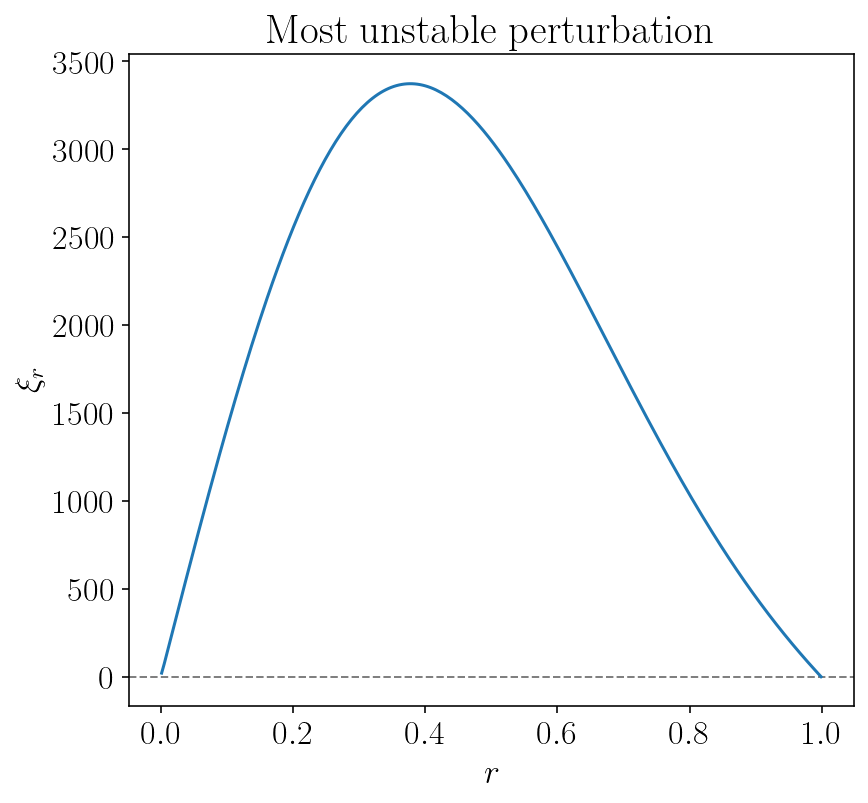

In [8]:
# How to evaluate the dispersion function D(l;k), given (alpha,q), (m,k) a value l for lambda.
# In this case, we also choose to plot
alpha = 1
q = 0.4
m = 2
k = -1.99*q
l = 5.29e-8
print('Dispersion function = ', disp_F(l, m, k, q, alpha, printsol = True))

# Plotting the dispersion function

In [9]:
def lineplot(x, y, axes, title, markzero = False):
    fig, ax = set_basics(title, axes, markzero)
    ax.plot(x,y)
    plt.text(0, 2.73, f'$m = {m}$', bbox=dict(boxstyle="round", ec=(0.0, 0.0, 0.0), fc=(1., 1, 1)), color = 'black')

In [10]:
def plot_dispersion_function(alpha, q, m, k, ls, normalized = True):
    D = []
    for l in ls:
        D.append(disp_F(l, m, k*q, q, alpha))
    D = D/np.mean([abs(x) for x in D]) if normalized else D
    axes = ['$\lambda$', '$D(\lambda; k)$']
    title = r'Disp. fun. for $(\alpha, q) = (%1.0f, %1.1f)$, $k/q=%1.2f$'%(alpha, q, k)
    lineplot(ls, D, axes, title, markzero = True)

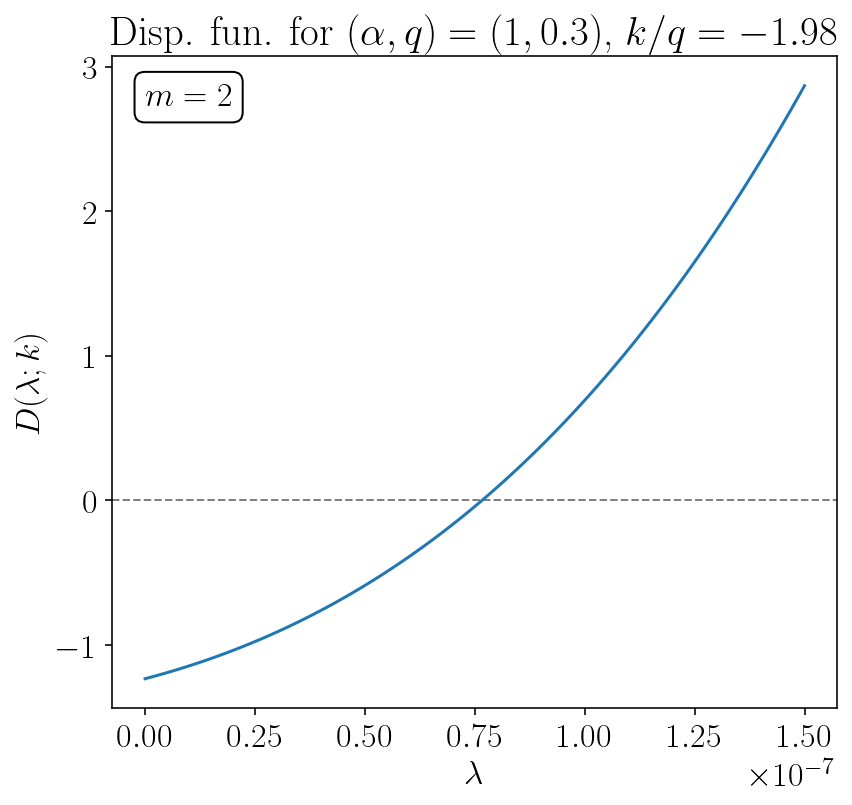

In [11]:
m=2
alpha = 1
q = 0.30
k = -1.98
lmax = 1.5e-7
lmin = 0.0005*lmax
lambdas = np.linspace(lmin,lmax,100)
plot_dispersion_function(alpha, q, m, k, lambdas)

In [12]:
def comparison_lineplot(x, ys, prelabel, labels, axes, title, posx, posy, markzero = False):
    fig, ax = set_basics(title, axes, markzero)
    for i in range(len(ys)):
        ax.plot(x[i],ys[i],label=prelabel + r' %1.3f'%(labels[i]))
    ax.legend(fancybox=True, shadow=True, facecolor='white')
    plt.legend(frameon = 1).get_frame().set_edgecolor('black')
    # The settings below are hardcoded
    ax.set_ylim([-2.2, 3.15])
    plt.text(posx, posy, f'$m = {m}$', bbox=dict(boxstyle="round", ec=(0.0, 0.0, 0.0), fc=(1., 1, 1)), color = 'black')

In [13]:
def plot_dispersion_functions(alpha, q, m, ks, ls, posx, posy):
    datax = []
    datay = []
    for k in ks:
        D = []
        for l in ls:
            D.append(disp_F(l, m, k*q, q, alpha))
        datax.append(ls)
        avg = np.mean([abs(x) for x in D]) # The dispersion function is being normalized for the comparison.
        datay.append(D/avg)
    prelabel = r'$k/q$ = '
    axes = ['$\lambda$', 'normalized $D(\lambda; k)$']
    title = r'Dispersion function for $(\alpha, q) = (%1.0f, %1.1f)$'%(alpha, q)
    comparison_lineplot(datax, datay, prelabel, ks, axes, title, posx, posy, markzero = True)

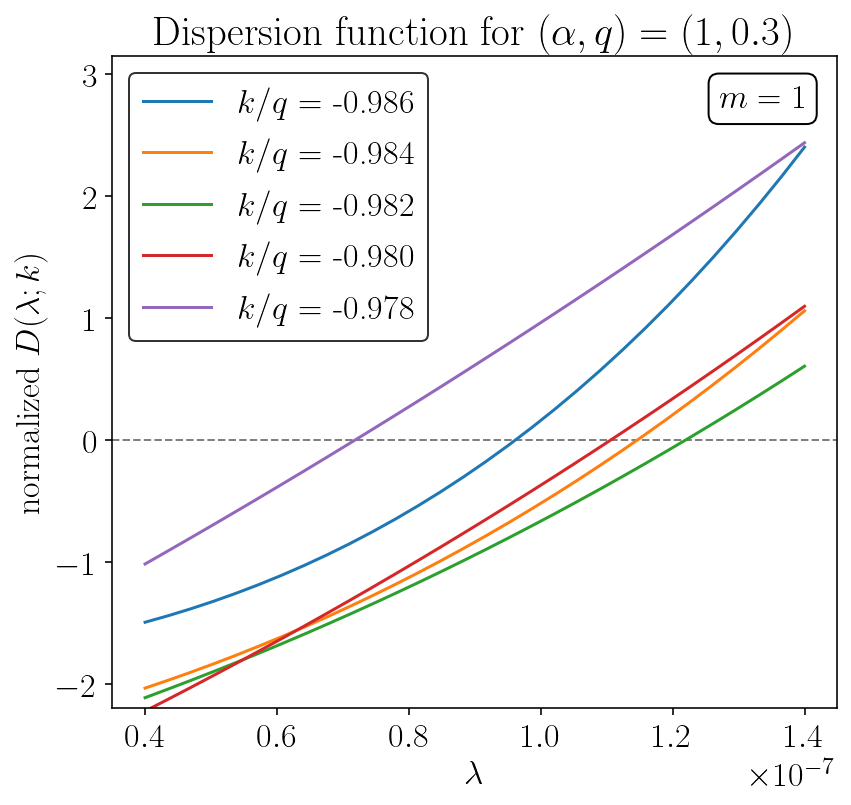

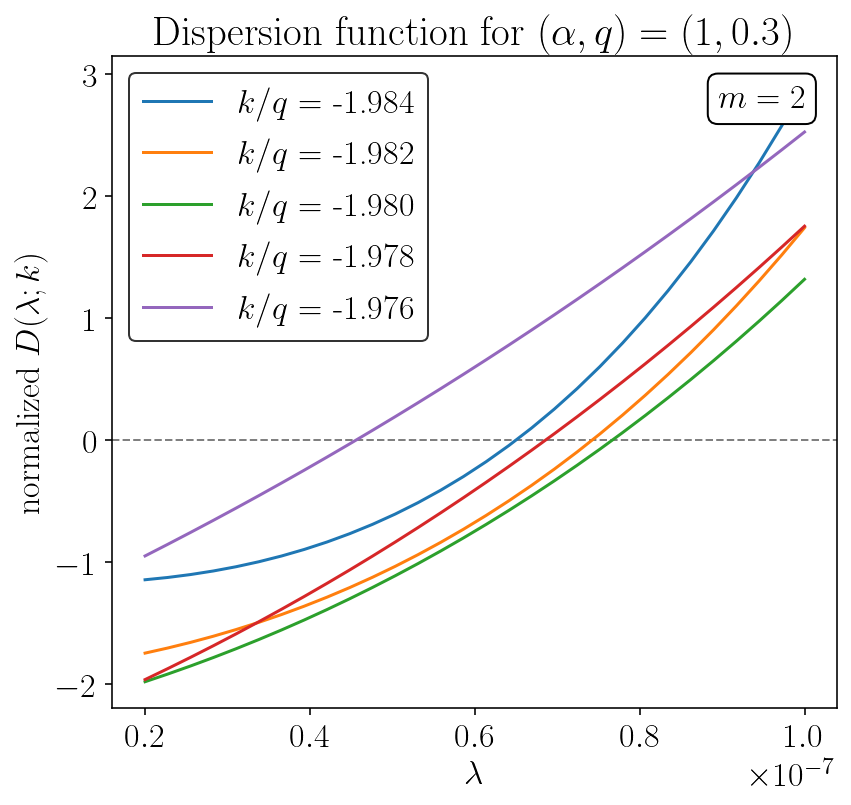

In [15]:
alpha = 1
q = 0.3
posy = 2.73

m = 1
ks = np.linspace(-0.986,-0.978,5) # Multiples of q
lambdas = np.linspace(0.4e-7,1.4e-7,30)
posx = 1.27e-7
plot_dispersion_functions(alpha, q, m, ks, lambdas, posx, posy)

m = 2
ks = np.linspace(-1.984,-1.976,5) # Multiples of q
lambdas = np.linspace(0.2e-7,1.0e-7,30)
posx = 0.895e-7
plot_dispersion_functions(alpha, q, m, ks, lambdas, posx, posy)

# Solving the dispersion equation

In [16]:
def lininterp(x0, y0, x1, y1, x2):
    m = (y1-y0)/(x1-x0)
    y2 = y1 + m*(x2-x1)
    return y2

# Finds the biggest root of a function in a given interval.
def biggest_root(func_Dlk, l_range):
    D_lk = []
    for l in l_range:
        D_lk.append(func_Dlk(l))
    all_same_sign = all(x > 0 for x in D_lk) or all(x < 0 for x in D_lk)
    if not all_same_sign:
        i = len(D_lk) - 1
        # We are only interested in finding the biggest zero.
        while np.sign(D_lk[i])*np.sign(D_lk[i-1]) > 0:
            i = i - 1
        # Linear interpolation to find the zero. We could do a dicotomic search, but it would be slower.
        return lininterp(D_lk[i-1], l_range[i-1], D_lk[i], l_range[i], 0)
    else:
        return 0

# Finds the dispersion relation between k and lambda, given the magnetic field configuration.
def dispersion_relation(alpha, q, m, k_vals, n_k, l_vals, n_l):
    ks = np.linspace(k_vals[0], k_vals[1], n_k)
    l_range = 10**(np.linspace(l_vals[0], l_vals[1], n_l)) # logarithmically spaced.
    ls = []
    for k in ks:
        D = []
        func_D = lambda l : disp_F(l, m, k, q, alpha) # Definition of a single variable function D(l).
        l = biggest_root(func_D, l_range)
        ls.append(l)
    return ks, ls

First, we look at one magnetic field configuration and several values of m. We observe that instabilities arise near k = -mq. Although we do not show it here, if q is increased one can check the range of unstable values of k becomes much wider.

In [21]:
def comparison_lineplot(x, ys, prelabel, labels, axes, title, markzero = False):
    fig, ax = set_basics(title, axes, markzero)
    for i in range(len(ys)):
        ax.plot(x[i],ys[i],label=prelabel + r' %1.0f'%(labels[i]))
    ax.legend(fancybox=True, shadow=True, facecolor='white')
    plt.legend(frameon = 1).get_frame().set_edgecolor('black')

In [28]:
def m_compare_dispersion_relation(ms, alpha, q, l_vals = [-14,-5], n_k = 60, n_l = 20):
    datax = []
    datay = []
    for m in ms:
        k_vals = [-1.3*m*q,-0.5*m*q]
        [k_range, ls] = dispersion_relation(alpha, q, m, k_vals, n_k, l_vals, n_l)
        datax.append(list(k_range/q))
        datay.append(ls)
    prelabel = r'$m$ = '
    labels = ms
    axes = ['$k/q$', '$\lambda$']
    title = r'Disp. relation for $\alpha =%1.1f$, $q =%1.1f$'%(alpha, q)
    comparison_lineplot(datax, datay, prelabel, labels, axes, title)

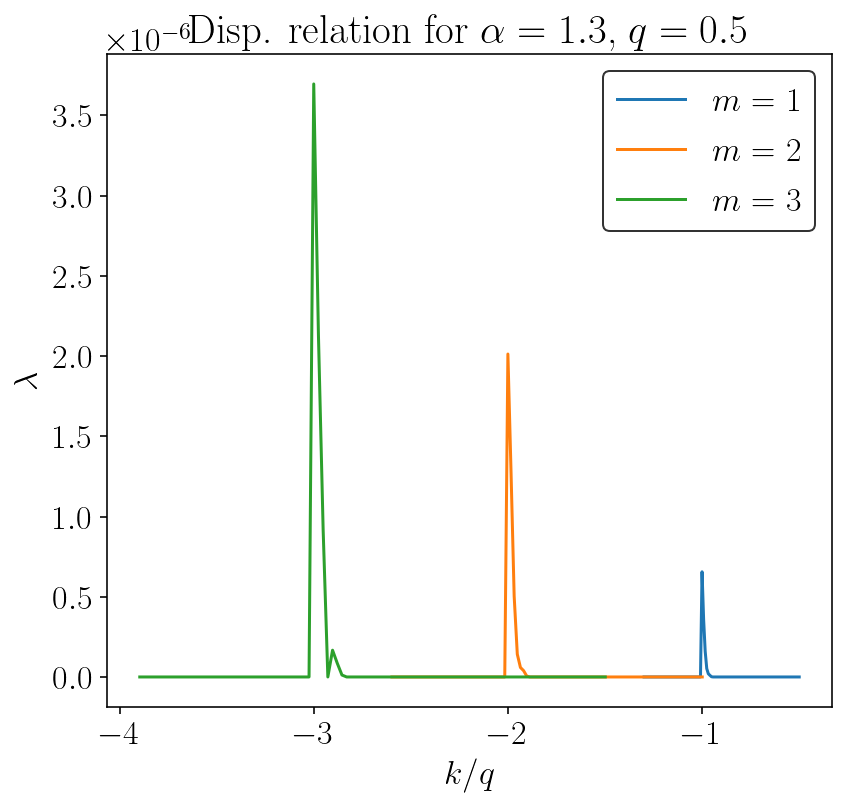

In [29]:
ms = [1,2,3]
alpha = 1.3
q = 0.5
m_compare_dispersion_relation(ms, alpha, q, l_vals = [-9,-1], n_k = 100)

Now, we fix a value of m and compare the dispersion relation for several values of q.

In [30]:
# Finds the dispersion relation for several magnetic field configurations, and plots them in the same figure.
# "eps" allows to focus in a given range of values of k, centered at -q.
# "l_vals" is the range of exponents in base 10 for lambda which is being considered to look for a solution.
# Thus, it may have to be adjusted when changing the magnetic field configuration.
# "n_k" and "n_l" can be modified to change on the degree of accuracy.
def q_compare_dispersion_relation(alpha, qs, m, posx, posy, eps = 0.05, l_vals = [-14,-5], n_k = 60, n_l = 20):
    datax = []
    datay = []
    for q in qs:
        k_vals = [-q*(m+eps/4), -q*(m-eps)]
        [k_range, ls] = dispersion_relation(alpha, q, m, k_vals, n_k, l_vals, n_l)
        datax.append(list(k_range/q))
        datay.append(ls)
    prelabel = r'$q$ = '
    labels = qs
    axes = ['$k/q$', '$\lambda$']
    title = r'Dispersion relation for $\alpha =%1.0f$'%(alpha)
    comparison_lineplot(datax, datay, prelabel, labels, axes, title, posx, posy)

In [31]:
def comparison_lineplot(x, ys, prelabel, labels, axes, title, posx, posy, markzero = False):
    fig, ax = set_basics(title, axes, markzero)
    for i in range(len(ys)):
        ax.plot(x[i],ys[i],label=prelabel + r' %1.2f'%(labels[i]))
    ax.legend(fancybox=True, shadow=True, facecolor='white')
    plt.legend(frameon = 1).get_frame().set_edgecolor('black')
    # The settings below are hardcoded
    ax.set_ylim([0, 3.2e-7])
    plt.text(posx, posy, f'$m = {m}$', bbox=dict(boxstyle="round", ec=(0.0, 0.0, 0.0), fc=(1., 1, 1)), color = 'black')

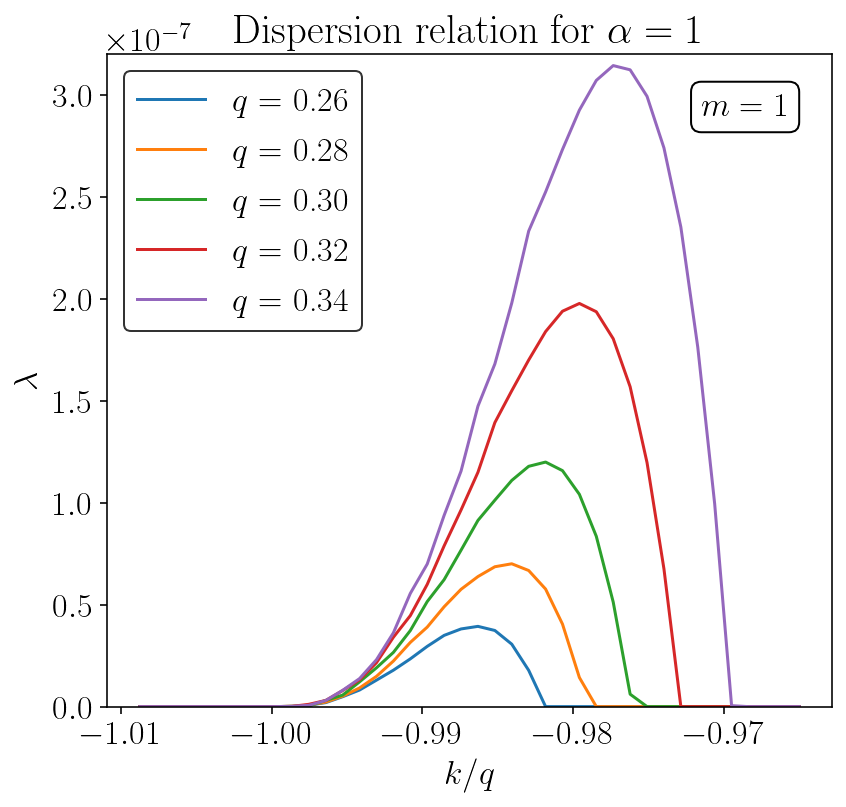

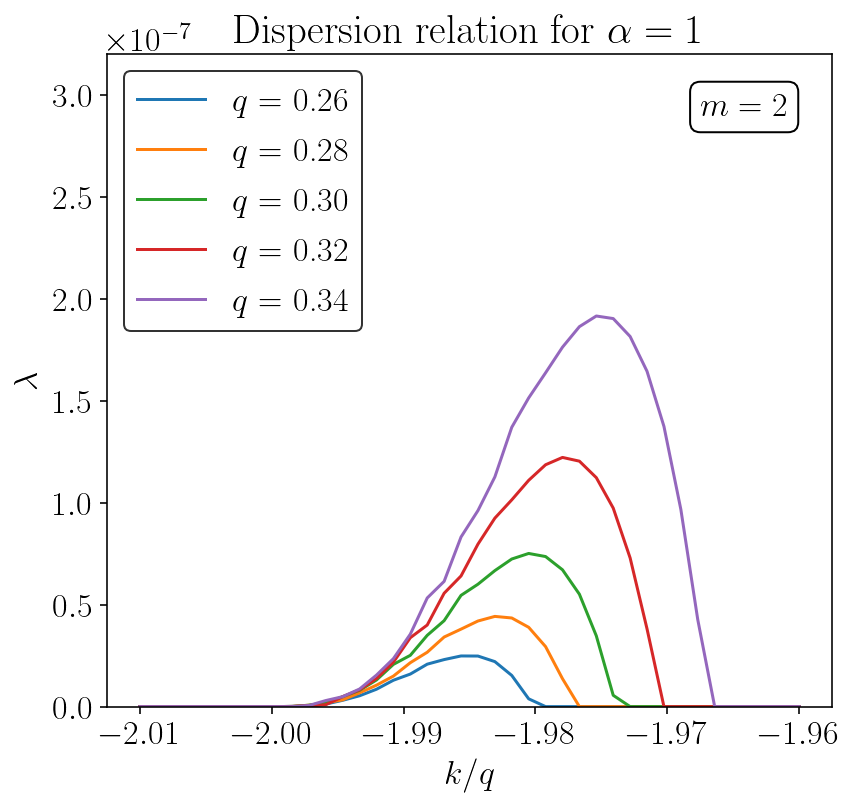

In [33]:
alpha = 1
qs = [0.26, 0.28, 0.30, 0.32, 0.34]
posy = 2.9e-7

m=1
posx = -0.9715
q_compare_dispersion_relation(alpha, qs, m, posx, posy, eps = 0.035, l_vals = [-10,-6], n_k = 40)

m = 2
posx = -1.9675
q_compare_dispersion_relation(alpha, qs, m, posx, posy, eps = 0.04, l_vals = [-10,-6], n_k = 40)

# Finding the max growth rate for each magnetic field configuration

In [34]:
def lambdamax(alpha, q, m, k_vals, n_k, l_vals, n_l):
    k_range = np.linspace(k_vals[0], k_vals[1], n_k)
    l_range = 10**(np.linspace(l_vals[0], l_vals[1], n_l)) # logarithmically spaced.
    lmax = 0
    kmax = 0
    for k in k_range:
        func_Dlk = lambda l : disp_F(l, m, k, q, alpha) # Definition of a single variable function D(l).
        l = biggest_root(func_Dlk, l_range)
        if l > lmax:
            lmax = l
            kmax = k
    return lmax, kmax

# Range of k's where we look for the maximum of the dispersion relation l(k). Could be improved.
def get_k_vals(m, q, eps = 0.05):
    return [-q*(m+eps/3), -q*(m-eps)]

In [35]:
ms = [1,2,3,4]
qs = np.linspace(0.2, 0.8, 20)

The cell below should be executed for both alpha = 1 and alpha = 1.5. The execution process is slow, so the results are saved into an excel sheet. This has already been done, and the excel sheets have been renamed to 'sheet_alpha1.csv' and 'sheet_alpha1.5.csv' respectively. Hence, there is no need to execute the cell below to obtain the plots shown in the thesis. However, it can be used to obtain similar plots, varying the value of alpha, de values of m, etc.

In [322]:
alpha = 1; l_vals = [-9,-3];
#alpha = 1.5; l_vals = [-12,-3];

n_k = 20
n_l = 20
lambdamaxs = []
for m in ms:
    this_curve = []
    print('Obtaining curve for m =', m)
    for q in qs:
        k_vals = get_k_vals(m, q)
        l = lambdamax(alpha, q, m, k_vals, n_k, l_vals, n_l)[0]
        this_curve.append(l)
        print(r'For q = ' + str(np.round(q,3)) + ', lambda = ' + str(l))
    print('')
    lambdamaxs.append(this_curve)
    
# Save as csv
np.savetxt('sheet_'+str(uuid.uuid4())+'.csv', lambdamaxs, delimiter=',')

Obtaining curve for m = 1
For q = 0.2, lambda = 4.91229980640547e-09
For q = 0.232, lambda = 1.556871076496698e-08
For q = 0.263, lambda = 4.1606028471223544e-08
For q = 0.295, lambda = 1.0023312137231849e-07
For q = 0.326, lambda = 2.230505960316494e-07
For q = 0.358, lambda = 4.5479291475251767e-07
For q = 0.389, lambda = 8.590760806444377e-07
For q = 0.421, lambda = 1.5729901887376926e-06
For q = 0.453, lambda = 2.753440519277994e-06
For q = 0.484, lambda = 4.412475418879104e-06
For q = 0.516, lambda = 7.044270102130538e-06
For q = 0.547, lambda = 9.950230316313086e-06
For q = 0.579, lambda = 1.3239282378903382e-05
For q = 0.611, lambda = 1.532669088268656e-05
For q = 0.642, lambda = 1.787829020803377e-05
For q = 0.674, lambda = 2.1279175244629843e-05
For q = 0.705, lambda = 2.638348300574868e-05
For q = 0.737, lambda = 2.7469331185359824e-05
For q = 0.768, lambda = 2.860406236611749e-05
For q = 0.8, lambda = 2.9834691517709942e-05

Obtaining curve for m = 2
For q = 0.2, lambda = 2.

In [36]:
# Load the max growth rate data from the re-named csv sheets
data1 = np.loadtxt('sheet_alpha1.csv', delimiter=',')
data2 = np.loadtxt('sheet_alpha1.5.csv', delimiter=',')

In [37]:
def comparison_lineplot(x, ys, prelabel, labels, axes, title, markzero = False):
    fig, ax = set_basics(title, axes, markzero)
    for i in range(len(ys)):
        ax.plot(x[i],ys[i],label=prelabel + r' %1.0f'%(labels[i]))
    ax.legend(fancybox=True, shadow=True, facecolor='white')
    plt.legend(frameon = 1).get_frame().set_edgecolor('black')
    # The settings below are hardcoded
    plt.grid()
    ax.set_yscale('log')
    ax.set_ylim([1e-9, 2e-4])

In [38]:
def max_growth_plot(datay, alpha):
    datax = [qs, qs, qs, qs]
    datay = datay
    prelabel = r'$m$ = '
    labels = ms
    axes = [r'$q$', r'$\lambda_{max}$']
    title = 'Max. growth rate comparison'
    title = r'Max. growth rate comparison for $\alpha =%1.1f$'%(alpha)
    comparison_lineplot(datax, datay, prelabel, labels, axes, title)

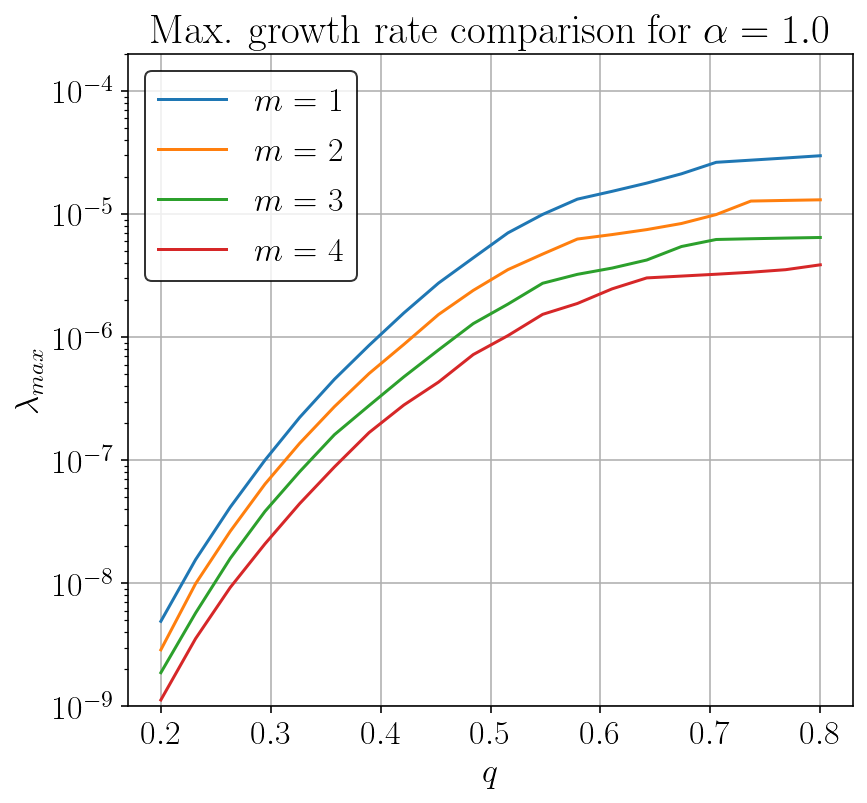

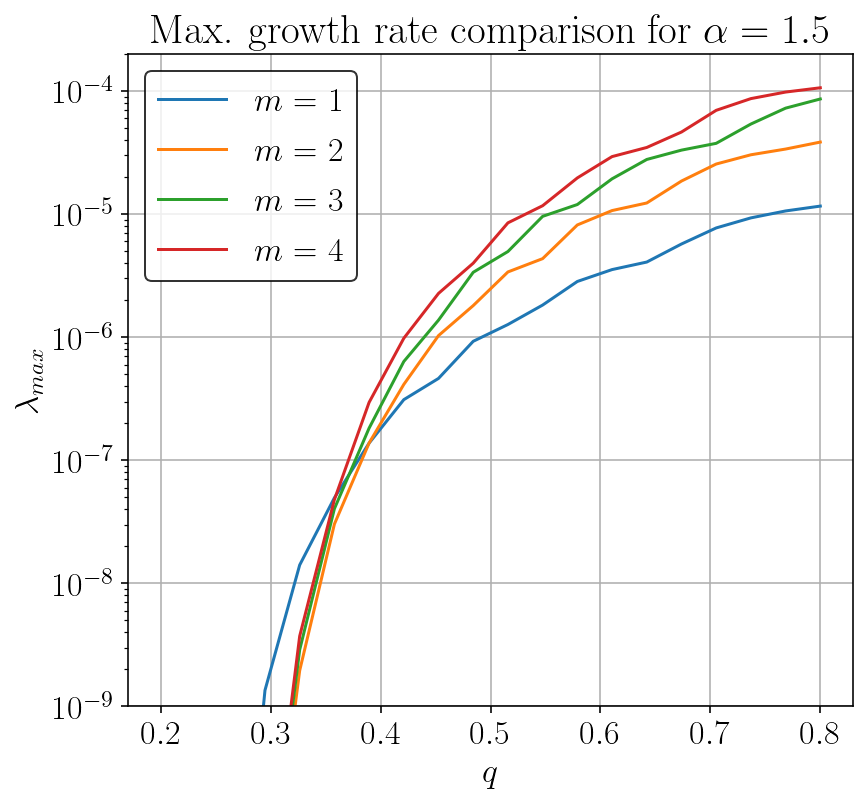

In [39]:
max_growth_plot(data1, 1)
max_growth_plot(data2, 1.5)

# Finding the "critical q" for each alpha, given a threshold l0

In [40]:
def critical_q(alpha, l0, qmin, qmax, eps = 0.05, tol = 0.01, n_k = 20, n_l = 10):
    l_vals = [np.log10(l0)-0.5, np.log10(l0)+0.5]
    while (qmax - qmin > tol):
        #print(round(qmin,2), round(qmax,2))
        qmid = (qmin + qmax)/2
        k_vals = get_k_vals(m, qmid, eps = eps)
        lmid = lambdamax(alpha, qmid, m, k_vals, n_k, l_vals, n_l)[0]
        if (lmid < l0):
            qmin = qmid
        else:
            qmax = qmid
    q = (qmin + qmax)/2
    return q

In [41]:
m = 1
alpha = 1
l0 = 1e-7
[qmin, qmax] = [0.2, 0.8]
q = critical_q(alpha, l0, qmin, qmax)
print('Instability: m =', m)
print('Threshold: l0 =', l0)
print('Force parameter: alpha =', alpha)
print('Critical twist parameter: q =', q)

Instability: m = 1
Threshold: l0 = 1e-07
Force parameter: alpha = 1
Critical twist parameter: q = 0.2984375


In [42]:
# Determines a numpy array of values of alpha, spaced so that the plot looks nice.
def obtain_alphas(N = 30, alpha_min = 1, alpha_1 = 1.05, alpha_2 = 1.2, alpha_max = 1.5):
    a1 = np.linspace(alpha_min, alpha_1, int(N/3))
    a2 = np.linspace(alpha_1 + (alpha_2 - alpha_1)*3/N, alpha_2, int(N/3))
    a3 = np.linspace(alpha_2 + (alpha_max - alpha_2)*3/N, alpha_max, int(N/3))
    return np.concatenate((a1,a2,a3))

# Plot 4a: different thresholds

Again, the cell below takes time to execute, but the results have already been conveniently saved into the 'm1.csv' spreadsheet, so they can be used immediately to obtain the plots. Hence, there is no need to execute this cell.

In [ ]:
# Small alphas
m = 1
alphas = obtain_alphas()
ls = [4e-8, 7e-8, 1e-7]
qs = [[0.20, 0.55], [0.25, 0.60], [0.25, 0.60]]

crit_qs = []
for i in range(len(ls)):
    this_curve = []
    print('Obtaining curve for lambda =', ls[i])
    for alpha in alphas:
        q = critical_q(alpha, ls[i], qs[i][0], qs[i][1], tol = 0.002)
        this_curve.append(q)
        print(r'For alpha = ' + str(np.round(alpha,3)) + ', q = ' + str(np.round(q,3)))
    print('')
    crit_qs.append(this_curve)
np.savetxt('sheet_'+str(uuid.uuid4())+'.csv', crit_qs, delimiter=',')

In [43]:
def comparison_lineplot(x, ys, prelabel, labels, axes, title, markzero = False):
    fig, ax = set_basics(title, axes, markzero)
    for i in range(len(ys)):
        ax.plot(x[i],ys[i],label=prelabel + "{:.0e}".format(labels[i]))
    ax.legend(fancybox=True, shadow=True)
    plt.legend(frameon = 1).get_frame().set_edgecolor('black')
    plt.text(1.438, 0.267, f'$m = {m}$', bbox=dict(boxstyle="round", ec=(0.0, 0.0, 0.0), fc=(1., 1, 1)), color = 'black')
    ax.set_ylim([0.25, 0.58])

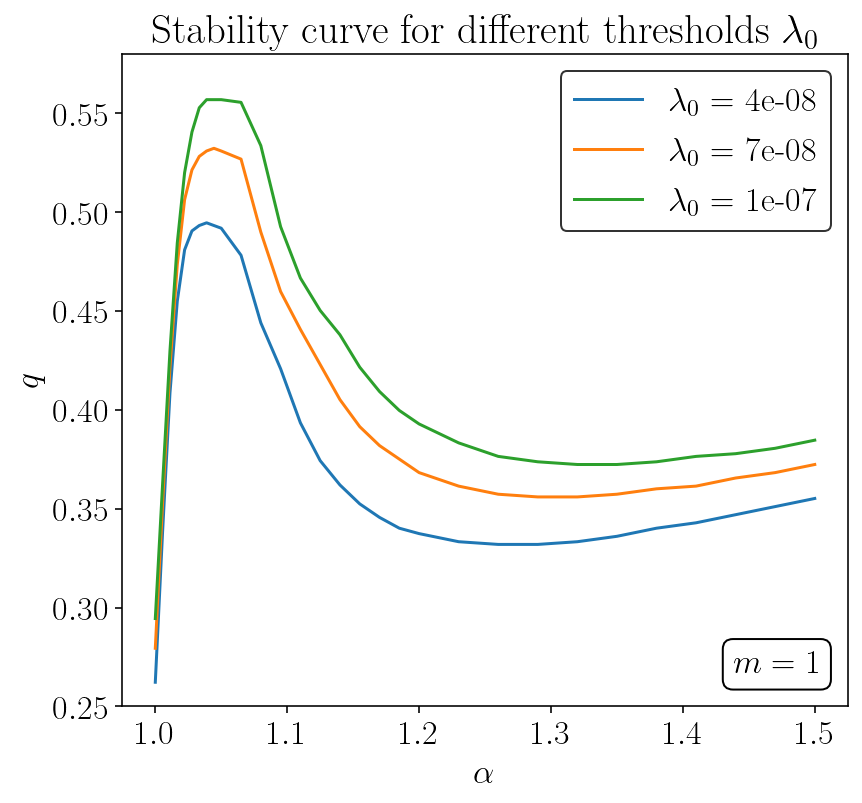

In [44]:
m = 1
datax = [obtain_alphas(), obtain_alphas(), obtain_alphas()]
datay = np.loadtxt('sheet_m1.csv', delimiter=',')
prelabel = r'$\lambda_0$ = '
labels = [4e-8, 7e-8, 1e-7]
axes = [r'$\alpha$', r'$q$']
title = 'Stability curve for different thresholds $\lambda_0$'
comparison_lineplot(datax, datay, prelabel, labels, axes, title)
#     ax.ticklabel_format(style='plain')

# Plot 4b: different m's

The cell below is the last of the cells that take so much time to execute. The results have been previously saved to 'l1e-7.csv'.

In [372]:
# Small alphas
l = 1e-7
alphas = obtain_alphas()
ms = [1, 2, 3]
qs = [[0.25, 0.60], [0.2, 0.75], [0.2, 0.5]]
crit_qs = []
for i in range(len(ms)):
    this_curve = []
    m = ms[i]
    print('Obtaining curve for m =', m)
    for alpha in alphas:
        q = critical_q(alpha, l, qs[i][0], qs[i][1], tol = 0.002)
        this_curve.append(q)
        print(r'For alpha = ' + str(np.round(alpha,3)) + ', q = ' + str(np.round(q,3)))
    print('')
    crit_qs.append(this_curve)
np.savetxt('sheet_'+str(uuid.uuid4())+'.csv', crit_qs, delimiter=',')

Obtaining curve for m = 1
For alpha = 1.0, q = 0.294
For alpha = 1.006, q = 0.363
For alpha = 1.011, q = 0.43
For alpha = 1.017, q = 0.484
For alpha = 1.022, q = 0.52
For alpha = 1.028, q = 0.541
For alpha = 1.033, q = 0.553
For alpha = 1.039, q = 0.557
For alpha = 1.044, q = 0.557
For alpha = 1.05, q = 0.557
For alpha = 1.065, q = 0.556
For alpha = 1.08, q = 0.534
For alpha = 1.095, q = 0.493
For alpha = 1.11, q = 0.467
For alpha = 1.125, q = 0.45
For alpha = 1.14, q = 0.438
For alpha = 1.155, q = 0.422
For alpha = 1.17, q = 0.409
For alpha = 1.185, q = 0.4
For alpha = 1.2, q = 0.393
For alpha = 1.23, q = 0.383
For alpha = 1.26, q = 0.376
For alpha = 1.29, q = 0.374
For alpha = 1.32, q = 0.372
For alpha = 1.35, q = 0.372
For alpha = 1.38, q = 0.374
For alpha = 1.41, q = 0.376
For alpha = 1.44, q = 0.378
For alpha = 1.47, q = 0.381
For alpha = 1.5, q = 0.385

Obtaining curve for m = 2
For alpha = 1.0, q = 0.311
For alpha = 1.006, q = 0.377
For alpha = 1.011, q = 0.428
For alpha = 1.017

In [45]:
def comparison_lineplot(x, ys, prelabel, labels, axes, title, markzero = False):
    fig, ax = set_basics(title, axes, markzero)
    colors = [u'#2ca02c', u'#ff7f0e', u'#1f77b4'] # inverted color cycle, to match the green line in the previous
    for i in range(len(ys)):
        ax.plot(x[i],ys[i],label=prelabel + r' %1.0f'%(labels[i]), color = colors[i])
    ax.legend(fancybox=True, shadow=True)
    plt.legend(frameon = 1).get_frame().set_edgecolor('black')
    plt.text(1.394, 0.267, r"$\lambda_0$ = {:.0e}".format(l), bbox=dict(boxstyle="round", ec=(0.0, 0.0, 0.0), fc=(1., 1, 1)), color = 'black')
    ax.set_ylim([0.25, 0.58])

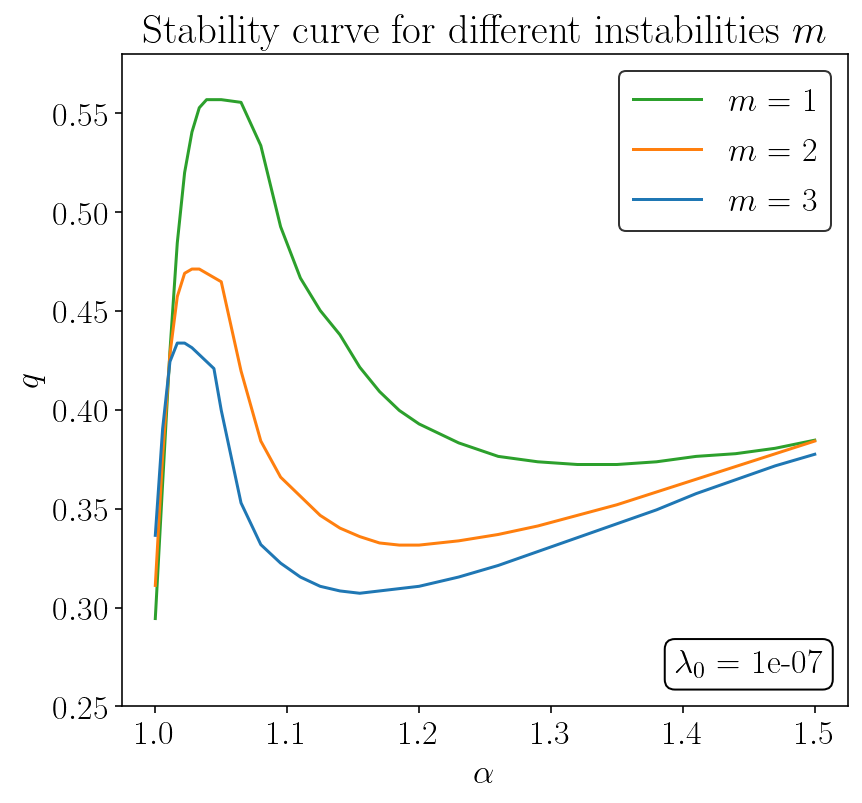

In [46]:
l = 10**(-7)
datax = [obtain_alphas(), obtain_alphas(), obtain_alphas()]
datay = np.loadtxt('sheet_l1e-7.csv', delimiter=',')
prelabel = r'$m$ = '
labels = [1, 2, 3]
axes = [r'$\alpha$', r'$q$']
title = 'Stability curve for different instabilities $m$'
comparison_lineplot(datax, datay, prelabel, labels, axes, title)

# Combining stability plots with twist and Lorentz forces

In [47]:
import matplotlib.patheffects as mpe

def line_colorplot(xi, yi, Z, label, ticks, cmap, x, ys, prelabel, labels, axes): 
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (6.5, 7.5)
    ax.set_xlabel(axes[0])
    ax.set_ylabel(axes[1])
    # Contourf:
    xi = np.array(xi); yi = np.array(yi); Z = np.array(Z)
    X, Y = np.meshgrid(xi, yi)
    im = plt.contourf(X, Y, Z, 100, cmap=plt.get_cmap(cmap))
    cb = plt.colorbar(im , ax = [ax], location = 'top', label=label)
    cb.set_ticks(ticks) 
    
    # Lines:
    #colors = [u'#2ca02c', u'#ff7f0e', u'#1f77b4'] # inverted color cycle, to match the green line in the previous
    pe1 = [mpe.Stroke(linewidth=3, foreground='black'), mpe.Stroke(foreground='black',alpha=1),mpe.Normal()]
    for i in range(len(ys)):
        ax.plot(x[i],ys[i],label=prelabel + r' %1.0f'%(labels[i]), linewidth = 2.3, path_effects=pe1)
    ax.legend(fancybox=True, shadow=True)
    plt.legend(frameon = 1).get_frame().set_edgecolor('black')
    ax.set_ylim([0.25, 0.58])
    plt.show()

In [48]:
# Lines that will be plotted
l = 10**(-7)
datax = [obtain_alphas(), obtain_alphas(), obtain_alphas()]
datay = np.loadtxt('sheet_l1e-7.csv', delimiter=',')
prelabel = r'$m$ = '
labels = [1, 2, 3]
axes = [r'$\alpha$', r'$q$']

In [49]:
N = 20
rr = np.linspace(0.01,1,100)
a = np.linspace(1,1.5,N)
q = np.linspace(0.25,0.58,N)

In [50]:
def Lorentz(a, q, r):
    mu0 = 1
    return (2*q**2*r)/(mu0*(q**2*r**2 + 1)**3) - (q*r**a*((q*r**a)/(q**2*r**2 + 1) - (2*q**3*r**a*r**2)/(q**2*r**2 + 1)**2 + (a*q*r*r**(a - 1))/(q**2*r**2 + 1)))/(mu0*r*(q**2*r**2 + 1))

def Twist(a, q, r):
    return q*r**(a-1)

def avg(f, param1, param2):
    rr = np.linspace(0.01,1,100)
    return np.mean(2*np.multiply(rr, np.abs(f(param1, param2, rr))))

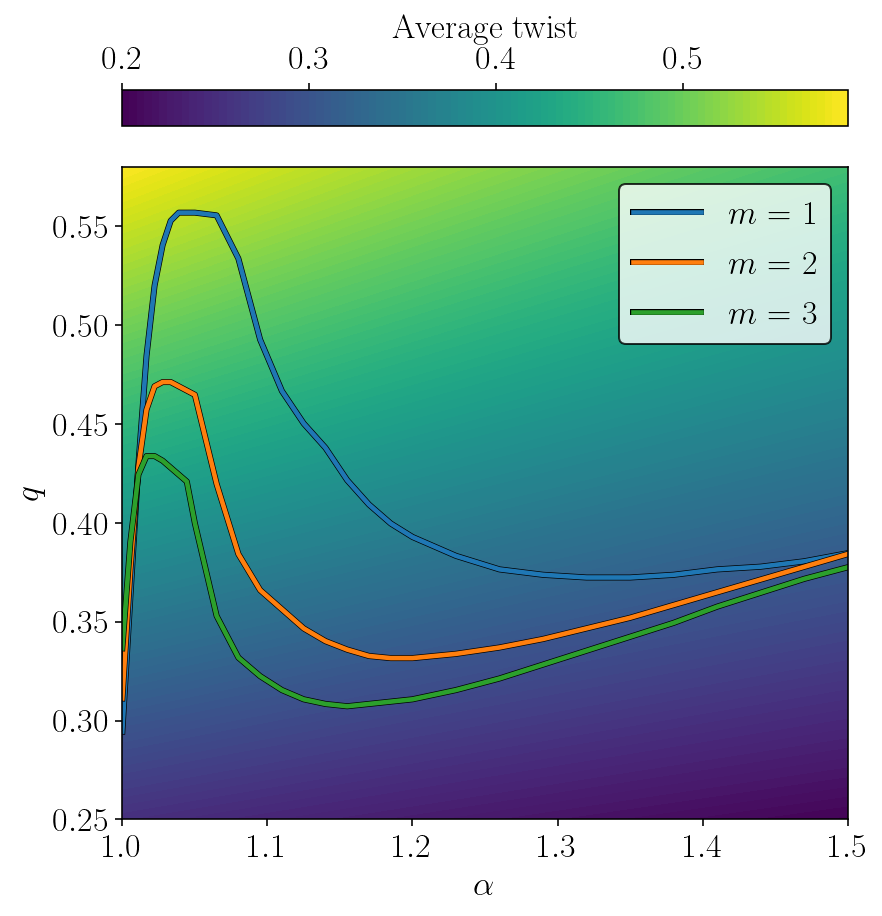

In [52]:
# Twist
Z = np.empty((N, N))
for i in range(N):
    for j in range(N):
        Z[i][j] = avg(Twist, a[j], q[i])
label = 'Average twist'
ticks = np.linspace(0,1,11)
cmap = 'viridis'
line_colorplot(a, q, Z, label, ticks, cmap, datax, datay, prelabel, labels, axes)

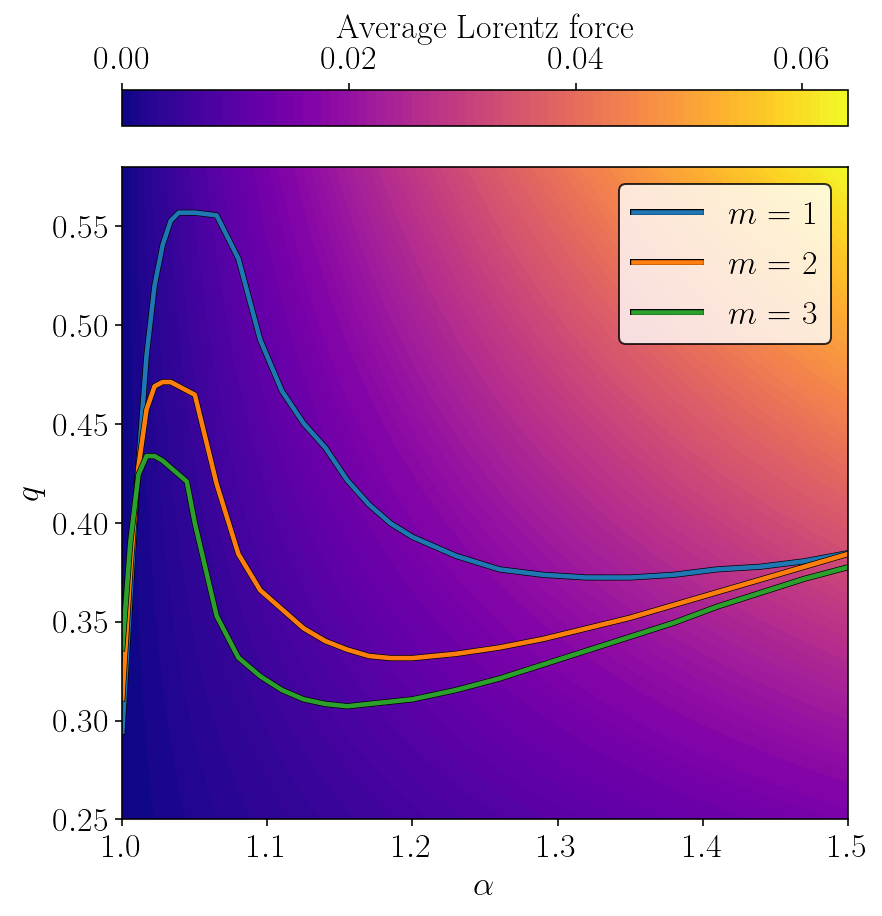

In [53]:
# Lorentz
Z = np.empty((N, N))
for i in range(N):
    for j in range(N):
        Z[i][j] = avg(Lorentz, a[j], q[i])
label = 'Average Lorentz force'
ticks = np.linspace(0,0.2,11)
cmap = 'plasma'
line_colorplot(a, q, Z, label, ticks, cmap, datax, datay, prelabel, labels, axes)

# Application to real data

We present a tool to roughly predict the time each instability takes to develop, given a reconstructed flux rope which has been fitted to the modified Gold-Hoyle model. This section is not included in the thesis.

In [54]:
def get_k_vals(m, q):
    return [-1.3*m*q,-0.5*m*q]

l_vals = [-7,-1]
n_k = 20
n_l = 40

In [55]:
def lambdamax(alpha, q, m, k_vals, n_k, l_vals, n_l):
    k_range = np.linspace(k_vals[0], k_vals[1], n_k)
    l_range = 10**(np.linspace(l_vals[0], l_vals[1], n_l)) # logarithmically spaced.
    lmax = 0
    kmax = 0
    for k in k_range:
        func_Dlk = lambda l : disp_F(l, m, k, q, alpha) # Definition of a single variable function D(l).
        l = biggest_root(func_Dlk, l_range)
        if l > lmax:
            lmax = l
            kmax = k
    return lmax, kmax

In [56]:
mp = 1.673e-27 # proton mass in kg
ratio = 1.16 # ratio between proton density and mass density (see equation 1.13 in thesis)
mu0 = 4*math.pi*1e-7 # magnetic permitivity
sec = 86400 # number of seconds in a day

def T_days(l, obs_B0, obs_R, obs_np):
    sigma = np.sqrt(l)
    T = 1/sigma
    obs_rho = ratio*mp*obs_np*1e6
    factor = (obs_R/obs_B0)*np.sqrt(mu0*obs_rho)
    T_d = T*factor/sec
    return T_d

def instability_times(ms, obs_B0, obs_R, obs_np, obs_alpha, obs_q):
    for m in ms:
        k_vals = get_k_vals(m, obs_q)
        l = lambdamax(obs_alpha, obs_q, m, k_vals, n_k, l_vals, n_l)[0]
        T_d = T_days(l, obs_B0, obs_R, obs_np)
        print('m =', m)
        print('Instability time:', np.round(T_d, 1), 'days')

In [59]:
# Maximum axial magnetic field in teslas
obs_B0 = 47e-9 

# Radius in meters
obs_R = 1.6e10

# Number of protons per cm^3.
obs_np = 20

# Magnetic field parameters
obs_alpha = 1.82
obs_q = 1.25

In [73]:
# Desired instabilities
ms = [1,2,3,4]
instability_times(ms, obs_B0, obs_R, obs_np, obs_alpha, obs_q)

m = 1
Instability time: 76.9 days
m = 2
Instability time: 42.4 days
m = 3
Instability time: 31.6 days
m = 4
Instability time: 26.5 days


If an event has been fitted to the Nieves-Chinchilla CC model, one can fit it to the modified Gold-Hoyle from there, in order to use the script above. This procedure is not the best, since more error is accumulated: it would be better to directly fit the experimental data using the modified GH model. However, it is a quick way to have an approximate idea of the instabilities that may take place in a given flux rope.

In [68]:
from numpy import linalg
from mag_field_Teresa import TBz, TBtheta, TdBz, TdBtheta

def Teresa_to_GH(n, m, Cnm, tau, qs, alphas, N):
    p = 1
    dist = float('inf')
    qmin = 0;
    alphamin = 0;
    r = np.linspace(0, 1, N)
    B_z = TBz(r, n, m, Cnm, tau)
    B_theta = TBtheta(r, n, m, Cnm, tau)
    for q in qs:
        for alpha in alphas:
            newB_z = Bz(r, q, alpha)
            newB_theta = Btheta(r, q, alpha)
            new_dist = np.sqrt(linalg.norm(newB_z - B_z, p)**2 + linalg.norm(newB_theta - B_theta,p)**2)
            if (new_dist < dist):
                dist = new_dist
                qmin = q
                alphamin = alpha
    return [qmin, alphamin]

def model_comparison(r,n,m,Cnm,tau,q,alpha):
    plt.rcParams["figure.figsize"] = (7.5, 6)
    plt.figure()
    plt.title(r"CC ($Cnm = {}$, $\tau = {}$) adjusted by GH ($q = {}$, $\alpha = {}$)".format(np.round(Cnm,2), np.round(tau,2), np.round(q,2), np.round(alpha,2)))
    plt.xlabel('$r$')
    plt.ylabel(r"Magnetic field component")
    plt.plot(r, TBtheta(r, n, m, Cnm, tau), 'g')
    plt.plot(r, TBz(r, n, m, Cnm, tau), 'b')
    plt.plot(r, Btheta(r, q, alpha), 'g--')
    plt.plot(r, Bz(r, q, alpha), 'b--')
    plt.legend([r"$B_\theta$", "$B_z$"])
    #plt.savefig(str(uuid.uuid4()))
    plt.show()

Best q: 1.25
Best alpha: 1.82


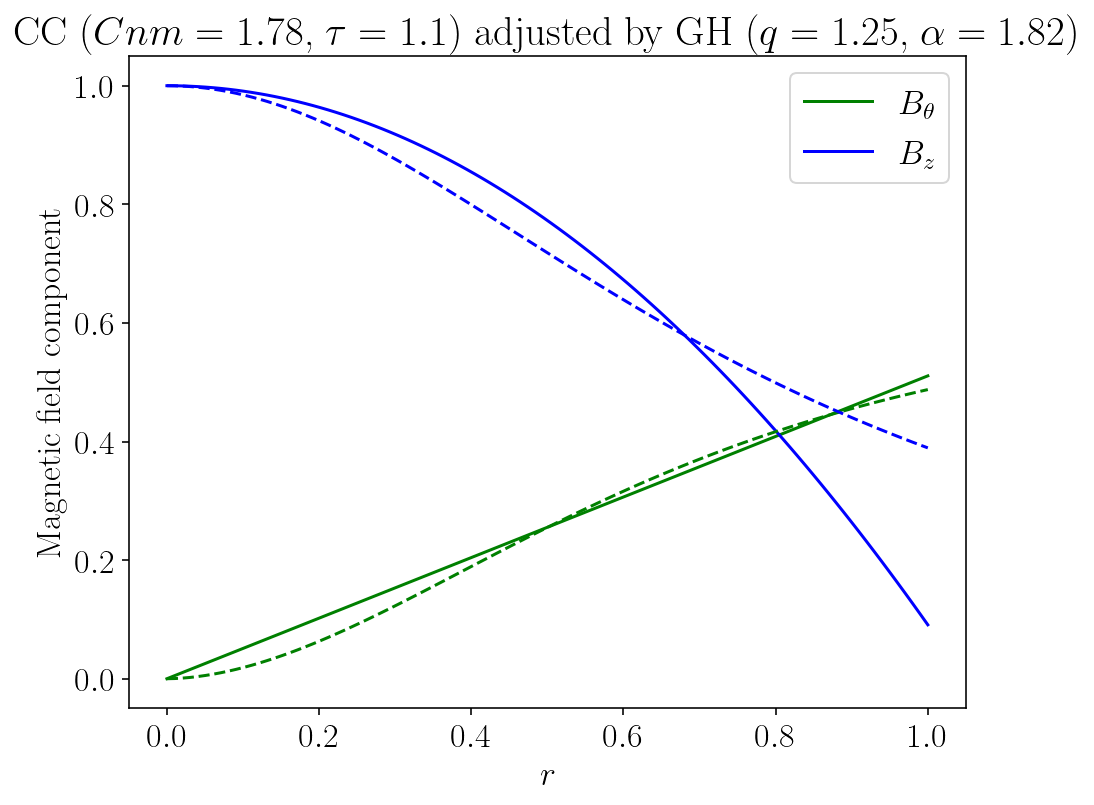

In [69]:
N = 100;
[n,m] = [1,0]
Cnm = 1.78 # [0.5,2]
tau = 1.1 # [0,4]
qs = np.linspace(0, 2, 100)
alphas = np.linspace(1, 10, 100)
[q_approx, alpha_approx] = Teresa_to_GH(n,m,Cnm,tau,qs,alphas,N)

print('Best q: ' + str(np.round(q_approx,2)))
print('Best alpha: ' + str(np.round(alpha_approx,2)))

r = np.linspace(0, 1, N)
model_comparison(r,n,m,Cnm,tau,q_approx,alpha_approx)